In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA

In [2]:
plt.rcParams.update({"font.size": 24})
plt.rcParams["figure.dpi"] = 400
plt.rcParams["figure.figsize"] = [15,15]
plt.rcParams['lines.linewidth'] = 0.9

In [11]:

rho_axon=1
r_axon=2e-6
R_factor=1
l_axon= R_factor* 1*0.1e-6
A_axon=np.pi*r_axon**2
R_a=  (rho_axon * l_axon)/A_axon
C_factor=1
C_m =C_factor*1e-6
print(f"Axon resistance: {R_a}")
num_axons=100
t_end  =	100e-3
dt     =	25e-6
T1     =    6.3
t = np.arange(0, t_end + dt, dt)
def temp_corr(T):
    k=3**(0.1*(T-6.3))
    return k

Axon resistance: 7957.7471545947665


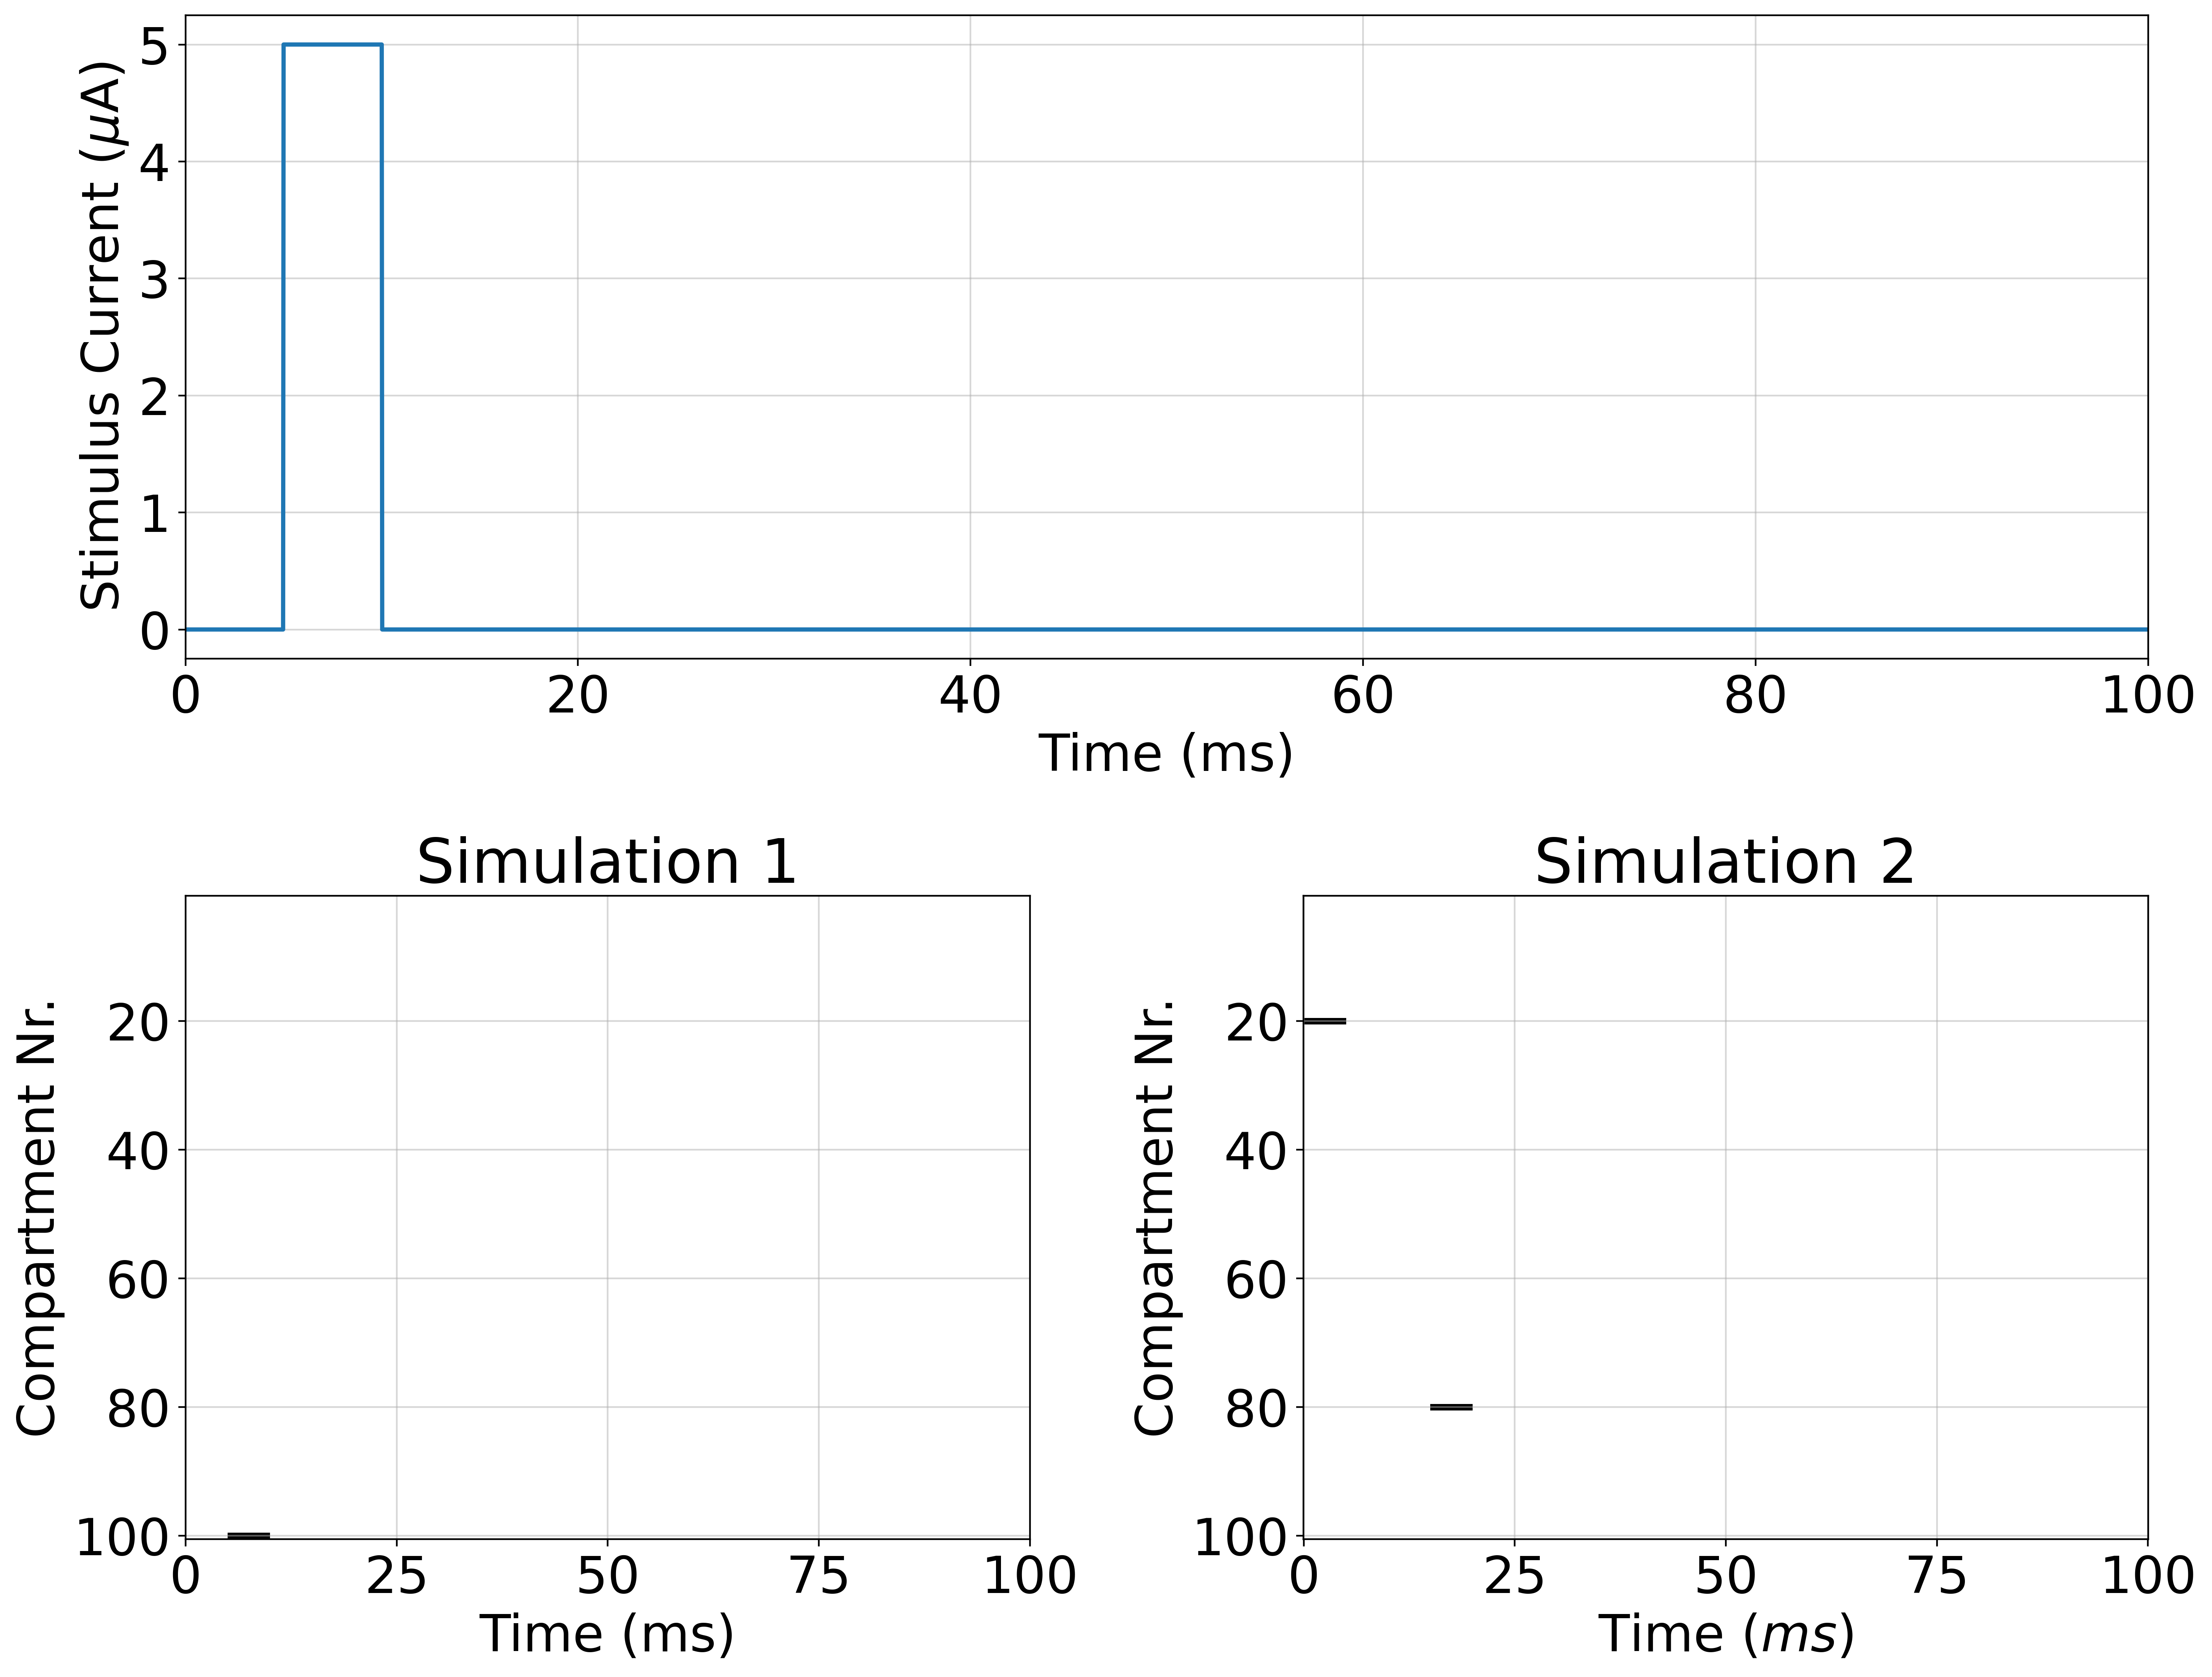

In [12]:
#input curretns:

pusles = [5e-6]
pulsewidth = 5e-3
gapwidth = 5e-3
offsets1 = [5e-3]
offsets2 = [0, 15e-3]
comp_stim1 = [num_axons - 1]
comp_stim2 = [19, 79]

def pulses(pulses, comps, t, gapwidth, pulsewidth, offsets):
    I_stim_comp = np.zeros((num_axons, len(t)))
    
    for k in range(len(pulses)):
        for idx, i in enumerate(t):
            for c, os in zip(comps,offsets):
                pulse_start = k * (gapwidth + pulsewidth) + os
                pulse_end = (k * gapwidth + (k + 1) * pulsewidth) + os
                if pulse_start <= i <= pulse_end:
                    I_stim_comp[c, idx] = pulses[k]
                
    return I_stim_comp

I_stim_comp1 = pulses(pusles, comp_stim1, t, gapwidth, pulsewidth, offsets1)
I_stim_comp2 = pulses(pusles, comp_stim2, t, gapwidth, pulsewidth, offsets2)



fig, axes = plt.subplot_mosaic("AA;BC",figsize=(15, 11.5))

axes["A"].plot(t * 1000, I_stim_comp1[99] * 1e6, lw=2)
axes["A"].set_xlabel("Time (ms)")
axes["A"].set_xlim(0,100)
axes["A"].set_ylabel("Stimulus Current ($\\mu$A)")
axes["A"].grid(alpha=0.5)

pcm1 = axes["B"].pcolormesh(t * 1000, np.arange(num_axons)+1, I_stim_comp1 * 1e6, cmap='binary', shading='auto')
axes["B"].set_xlabel("Time (ms)")
axes["B"].set_title("Simulation 1")
axes["B"].set_ylabel("Compartment Nr.")
axes["B"].invert_yaxis()
axes["B"].grid(alpha=0.5)

pcm2 = axes["C"].pcolormesh(t * 1000, np.arange(num_axons)+1, I_stim_comp2 * 1e6, cmap='binary', shading='auto')
axes["C"].set_xlabel("Time ($ms$)")
axes["C"].set_title("Simulation 2")
axes["C"].set_ylabel("Compartment Nr.")
axes["C"].invert_yaxis()
axes["C"].grid(alpha=0.5)

plt.tight_layout()
plt.savefig(f"Input.png")
plt.show()

In [5]:
alpha_m = lambda V , T: 1000*((2.5-100*V)/(np.exp(2.5-100*V)-1))*temp_corr(T)
alpha_m.__name__ = "m"
beta_m = lambda V, T: 4000*(np.exp((-500*V)/9))*temp_corr(T)

alpha_n = lambda V , T: 1000*((0.1-10*V)/(np.exp(1-100*V)-1))*temp_corr(T)
alpha_n.__name__ = "n"
beta_n = lambda V , T: 125*(np.exp((-25*V)/2))*temp_corr(T)

alpha_h = lambda V , T: 70*np.exp(-50*V)*temp_corr(T)
alpha_h.__name__ = "h"
beta_h = lambda V , T: 1000/(np.exp(3-100*V)+1)*temp_corr(T)

tau = lambda alpha, beta : 1/(alpha + beta)
x_inf = lambda alpha, beta : alpha/(alpha + beta)

alphas=[alpha_m,alpha_n,alpha_h]
betas=[beta_m,beta_n,beta_h]

In [6]:
def hh_gating(V, dt, curr_gate, T):

    new_gate_vec = []
    for V_s, gates in zip(V,curr_gate):
        new_gates = []
        for gate, a, b in zip(gates, alphas, betas):
            dx_dt = a(V_s, T) * (1 - gate) - b(V_s, T) * gate
            new_gate_x = gate + dx_dt * dt
            new_gates.append(new_gate_x)
        new_gate_vec.append(new_gates)
    
    return new_gate_vec
hh_gating([1e-3,1e-3],0.01e-3,[[0.2,0.2,0.4],[0.2,0.3,0.5]],T1)

[[0.19434788467299247, 0.20024639033016814, 0.40019090210597663],
 [0.19434788467299247, 0.3000612825075699, 0.5000721624831832]]

In [7]:
#connectionh matrix
C = np.zeros((num_axons, num_axons))
for i in range(num_axons-1):
    C[i, i + 1] = 1
    C[i + 1, i] = 1
for i in range(num_axons-2):
    C[i+1, i+1] = -2
C[0,0] = -1
C[num_axons-1,num_axons-1] = -1
C

array([[-1.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1., -2.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1., -2., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -2.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1., -2.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1., -1.]])

In [8]:
def hh_potential(V, dt, I_ions, I_stim):
    
    I_ion = np.sum(I_ions, axis=1)
    A = (np.identity(num_axons)- (dt/(C_m*R_a))*C)
    b = V+(dt/C_m)*(-1*I_ion+I_stim)
    
    V_new = LA.solve(A, b)

    return V_new
#hh_potential([1e-3,1e-3],0.001e-3,[[6e-3,3e-3,-2e-3],[6.5e-3,3.2e-3,-2.8e-3]],[0,1])

In [9]:
def hh_model(I_stim, t_end, dt):
    #params
    gNa = 120*1e-3
    gK = 36*1e-3
    gL = 0.3*1e-3
    
    VNa = 115*1e-3
    VK = -12*1e-3
    VL = 10.6*1e-3
    
    V = np.zeros((num_axons,len(t)))
    
    #matrices
    gates = np.zeros((num_axons, 3, len(t)))
    I_ions = np.zeros((num_axons, 3, len(t)))
    

    # calculate the rates (alpha and beta) for initial voltage
    alphas_0=[]
    betas_0=[]
    for s in range(0,num_axons):
        alphas_0_s=[]
        betas_0_s=[]
        for a, b in zip(alphas,betas):
            a_0 = a(V[s][0],T1)
            b_0 = b(V[s][0],T1)
            alphas_0_s.append(a_0)
            betas_0_s.append(b_0)
        alphas_0.append(alphas_0_s)
        betas_0.append(betas_0_s)
        
    # use the steady-state equations to obtain the initial gating variable states
    x_0=[]
    for s in range(0,num_axons):
        x_0_s=[]
        for a, b in zip(alphas_0[s],betas_0[s]):
            x = x_inf(a,b)
            x_0_s.append(x)
        x_0.append(x_0_s)
    for s in range(0,num_axons):    
        for i in range(3):
            gates[s][i][0] = x_0[s][i]
    
    I_ions = np.zeros((num_axons, 3, len(t)))
    
    for i in range(len(t) - 1):
        # Calculate ionic currents for the current timestep
        I_ions[:, 0, i] = gNa * gates[:, 0, i]**3 * gates[:, 2, i] * (V[:, i] - VNa)
        I_ions[:, 1, i] = gK * gates[:, 1, i]**4 * (V[:, i] - VK)
        I_ions[:, 2, i] = gL * (V[:, i] - VL)
    
        # Calculate gating variables for a future timestep
        gates[:, :, i + 1] = hh_gating(V[:, i], dt, gates[:, :, i], T1)
    
        # Calculate membrane potential for a future timestep
        V[:, i + 1] = hh_potential(V[:, i], dt, I_ions[:, :, i], I_stim[:, i + 1])
    
    return V, gates, I_ions, t

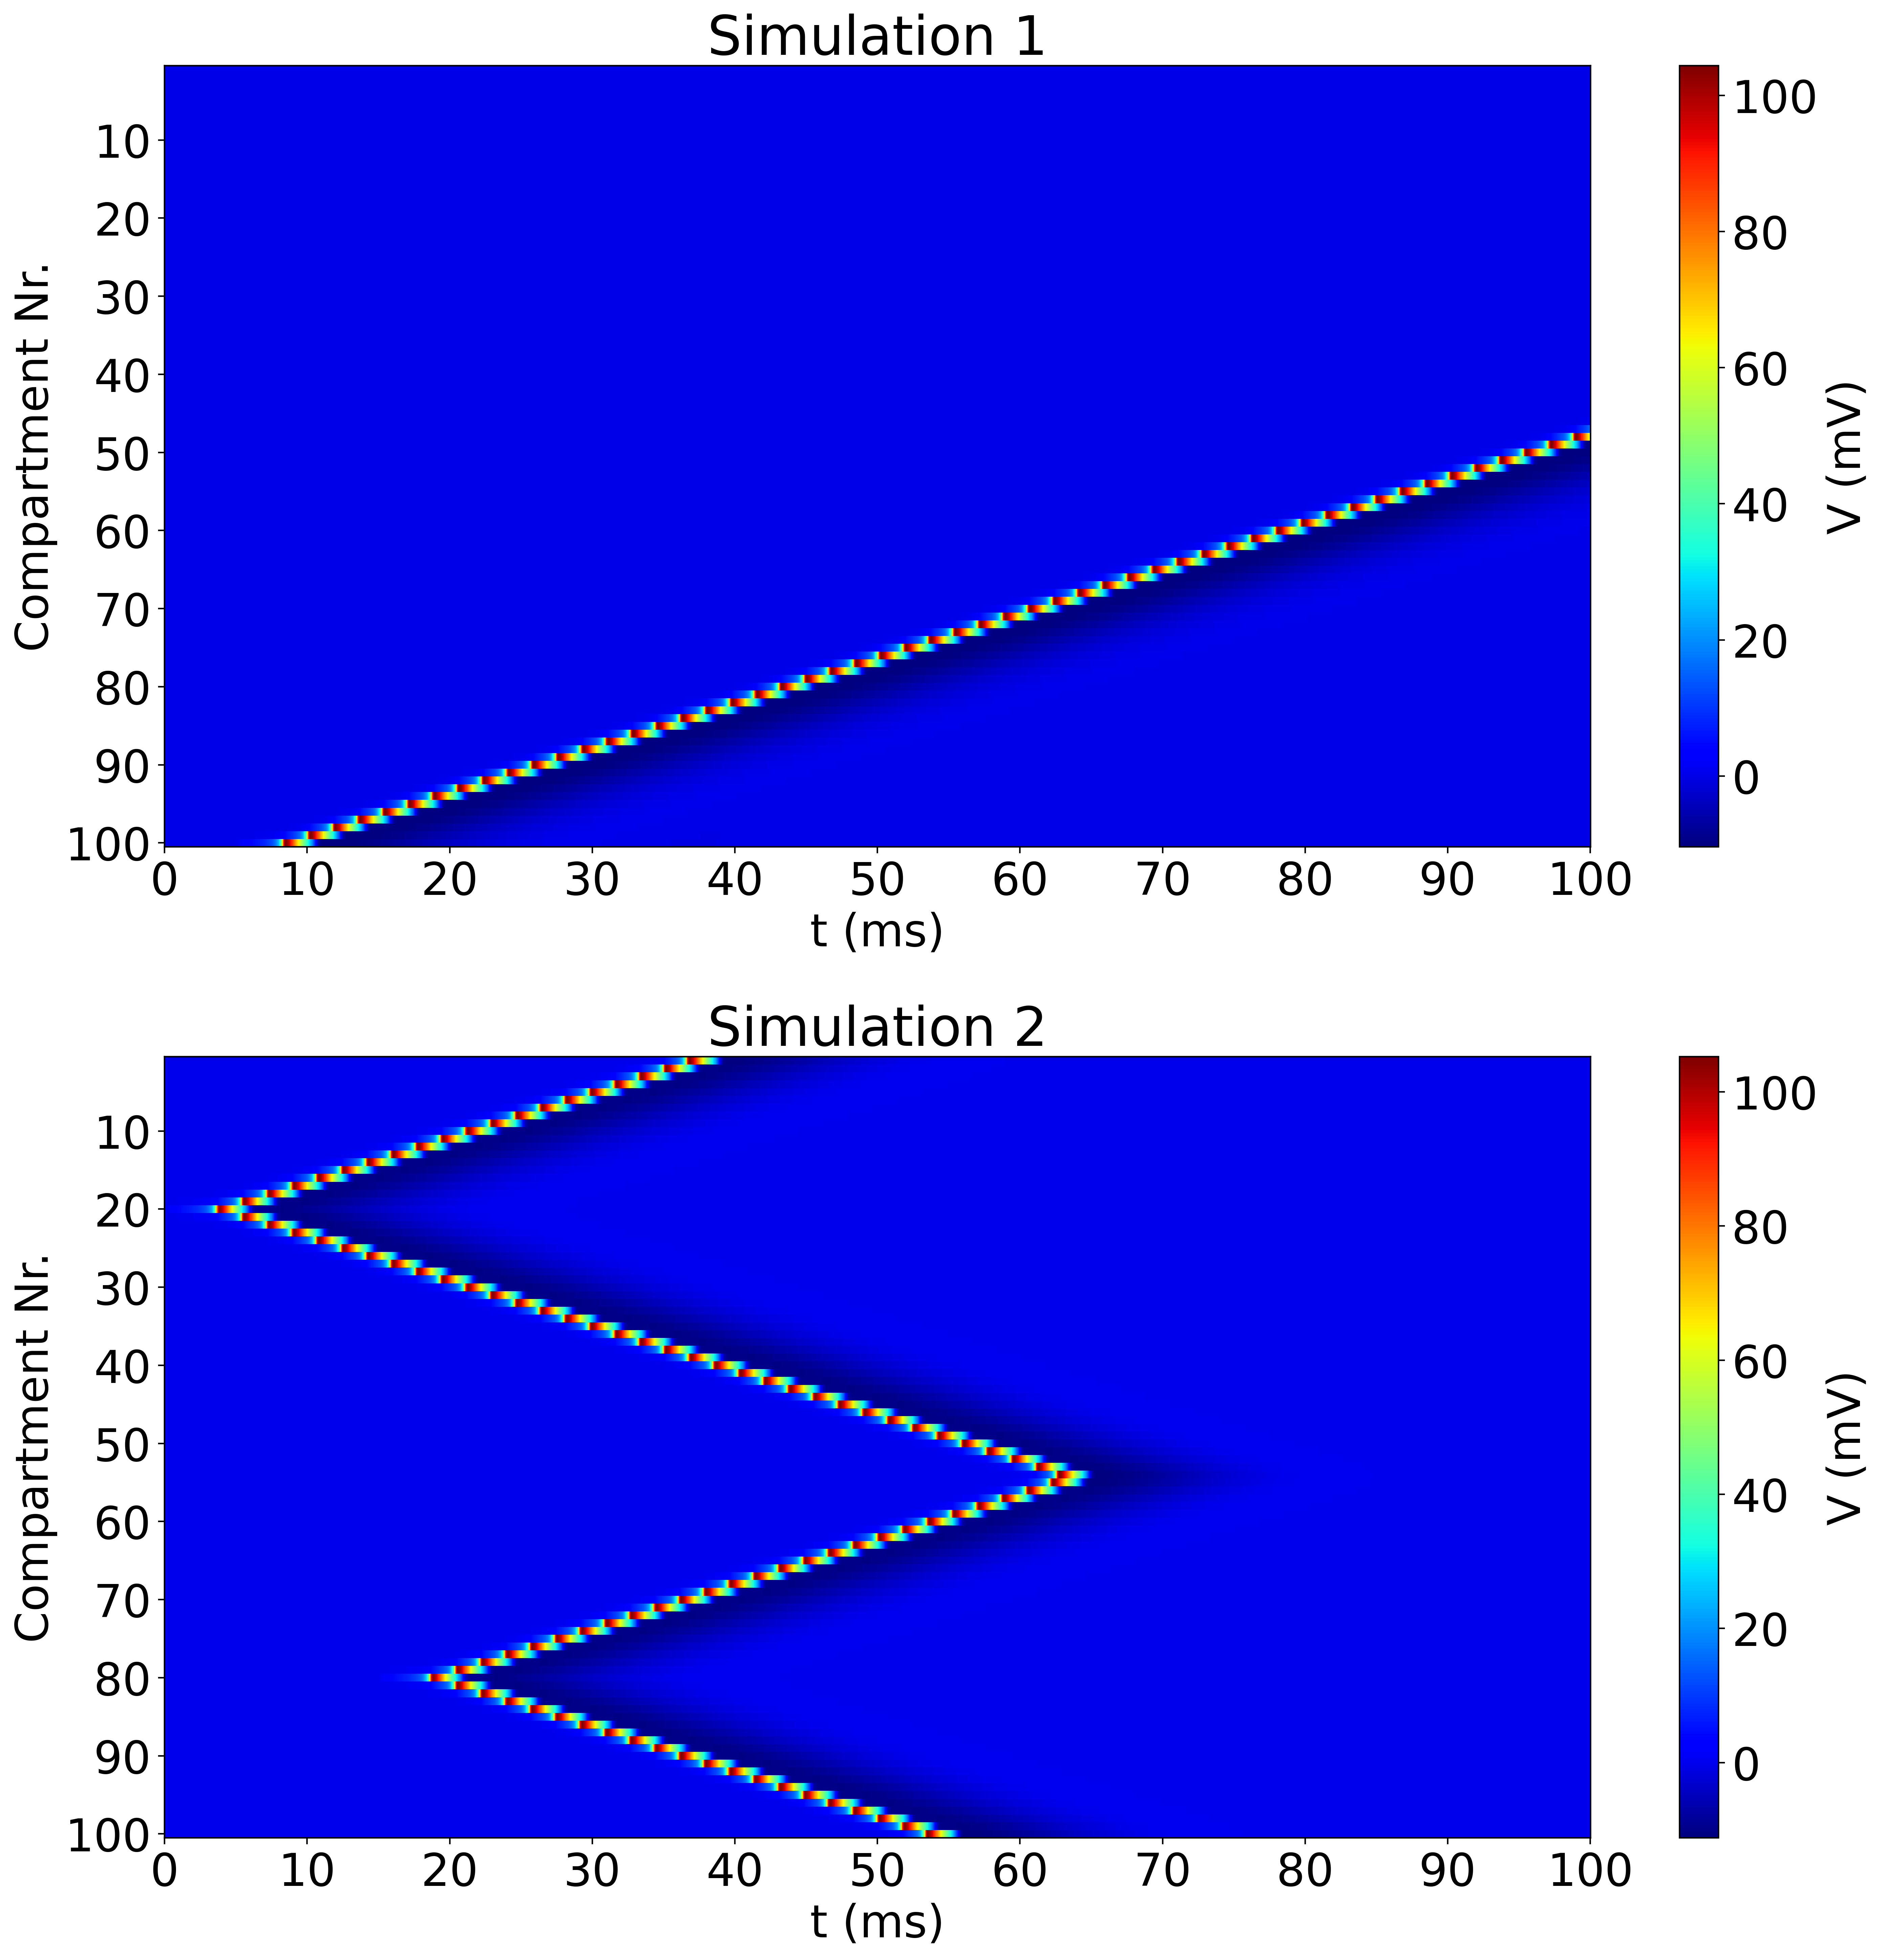

In [10]:
V1, gates1, I_ions1, t1 = hh_model(I_stim_comp1, t_end, dt)

V2, gates2, I_ions2, t2 = hh_model(I_stim_comp2, t_end, dt)

fig, ax1 = plt.subplots(2, 1)

comps = np.arange(1, num_axons + 1, 1)
img1 = ax1[0].pcolormesh(t1 * 1000, comps, V1 * 1000, cmap='jet', shading='auto')
colorbar1 = plt.colorbar(img1, ax=ax1[0])
colorbar1.set_label('V (mV)')
ax1[0].set_xlabel('t (ms)')
ax1[0].invert_yaxis()
ax1[0].set_ylabel('Compartment Nr.')
ax1[0].set_xticks(np.arange(0,110,10))
ax1[0].set_yticks(np.arange(10,110,10))
ax1[0].set_title("Simulation 1")

img2 = ax1[1].pcolormesh(t2 * 1000, comps, V2 * 1000, cmap='jet', shading='auto')
colorbar2 = plt.colorbar(img2, ax=ax1[1])
colorbar2.set_label('V (mV)')
ax1[1].invert_yaxis()
ax1[1].set_xlabel('t (ms)')
ax1[1].set_ylabel('Compartment Nr.')
ax1[1].set_xticks(np.arange(0,110,10))
ax1[1].set_yticks(np.arange(10,110,10))
ax1[1].set_title("Simulation 2")

plt.tight_layout()
#plt.savefig(f"Multicompartment.pdf")
plt.savefig(f"Multicompartment_C_{C_factor}_R_{R_factor}.png")
plt.show()

# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# for i in range(num_axons):
#     ax.plot(t,V[i],i)

# print(f"Voltage_shape: {V.shape}")
# print(f"gates1_shape: {gates.shape}")
# print(f"I_ions1_shape: {I_ions.shape}")
# print(f"t1_shape: {t.shape}")

# print(f"Voltage: {V}")
# print(f"gates1: {gates}")
# print(f"I_ions1: {I_ions}")
# print(f"t1: {t}")
